In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from scipy.optimize import curve_fit as cf
from math import floor
import os
from scipy.signal import find_peaks as pk

In [2]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4
#mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['font.size'] = 15
mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['axes.axisbelow'] = True

In [3]:
import os
os.environ['PINT_ARRAY_PROTOCOL_FALLBACK'] = "0"
import pint
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Q_([])

In [4]:
lineal = lambda x,a,b : a*x+b

def r2(y,x,lineal,pars):
    r2 = 1 - (np.sum((y-lineal(x,*pars))**2)/np.sum((y-np.mean(y))**2))
    return r2

def chi2_red(y,y_err,x,func,popt):
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    y_ajuste = func(x,*popt)
    
    chi_cuadrado = np.sum(((y-y_ajuste)/y_err)**2)
    chi_reducido = chi_cuadrado/grados_lib
    return chi_reducido

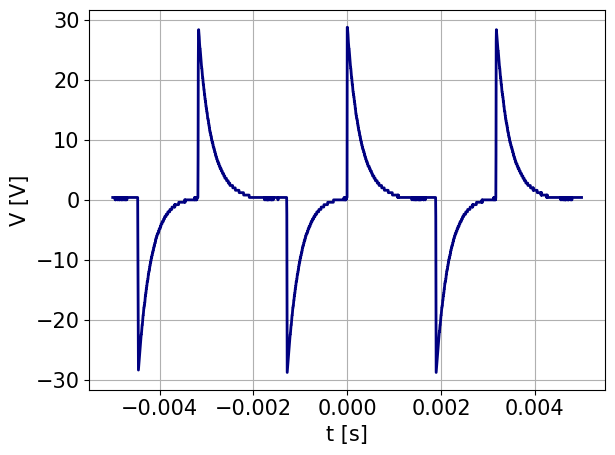

In [7]:
plt.plot(df.t,df.V_R,'navy')
plt.xlabel('t [s]')
plt.ylabel('V [V]')
plt.grid()
plt.tight_layout()
plt.savefig('plots/señal.png',bbox_inches='tight')

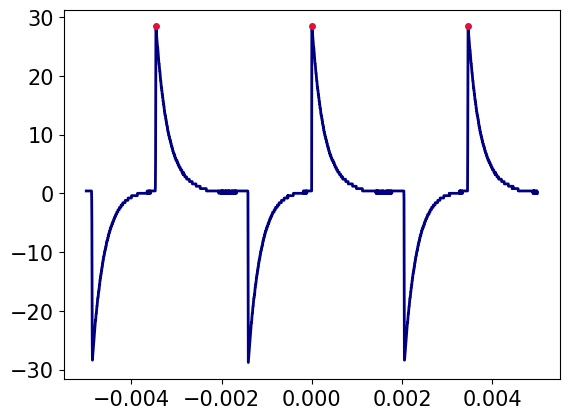

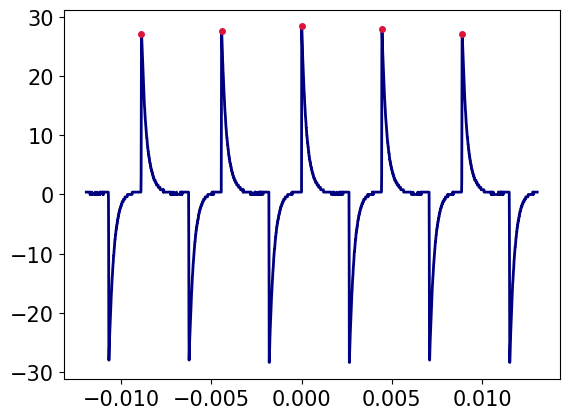

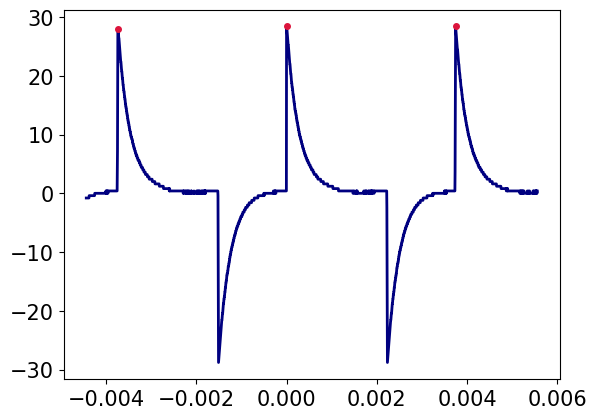

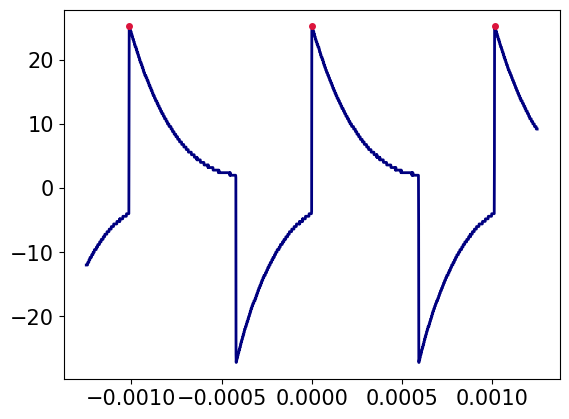

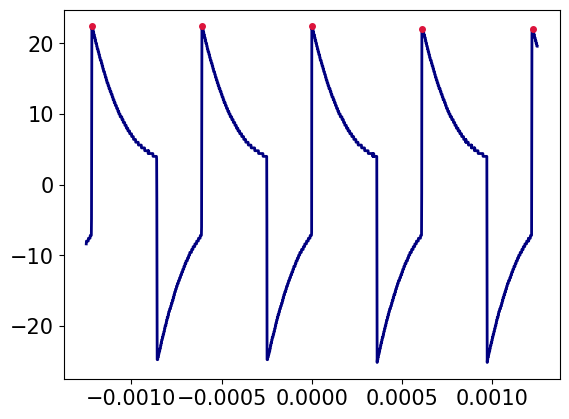

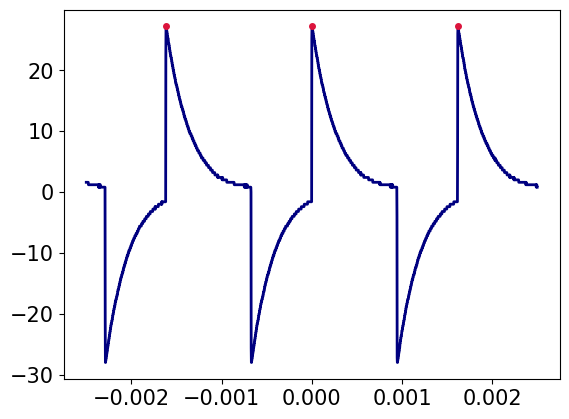

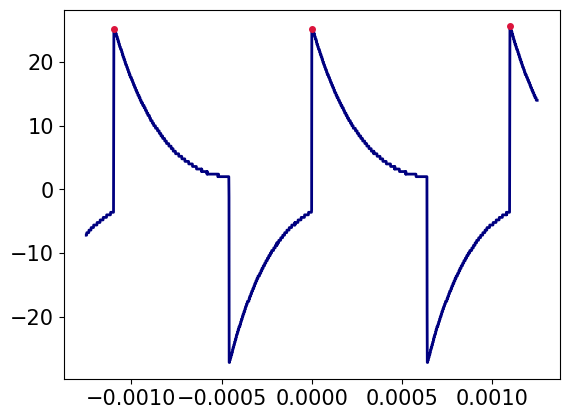

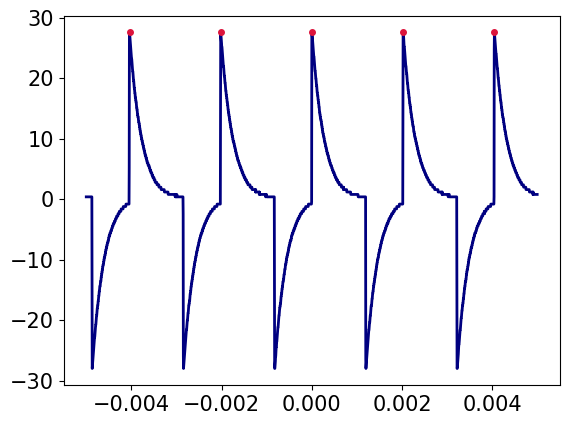

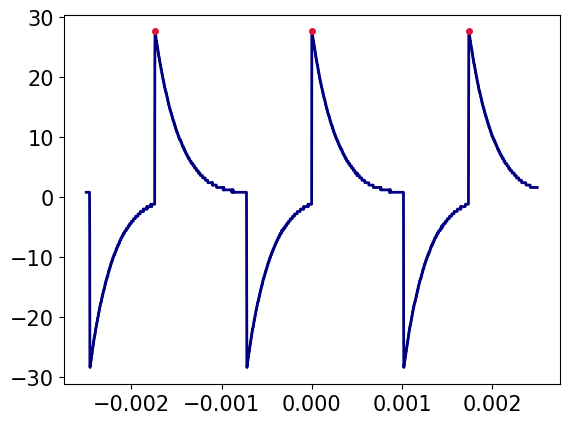

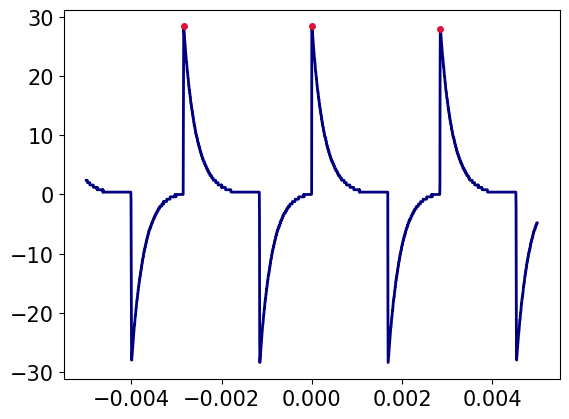

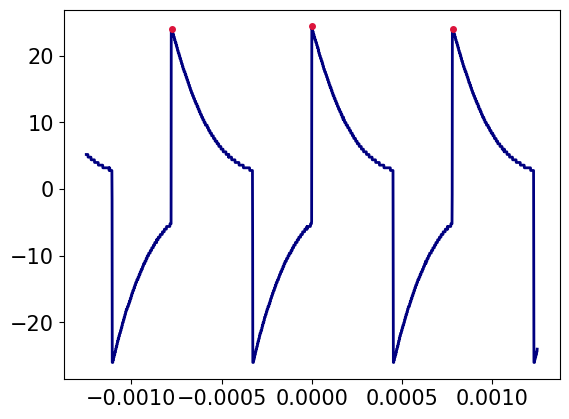

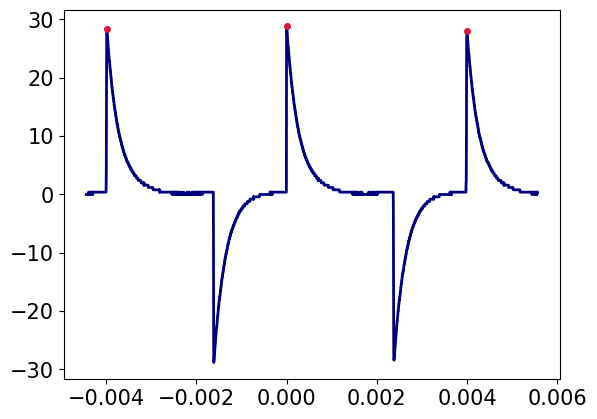

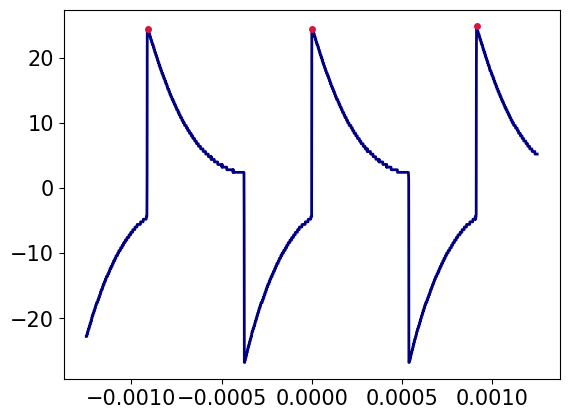

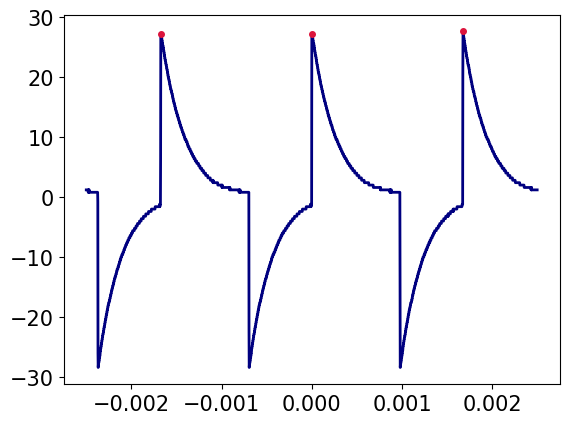

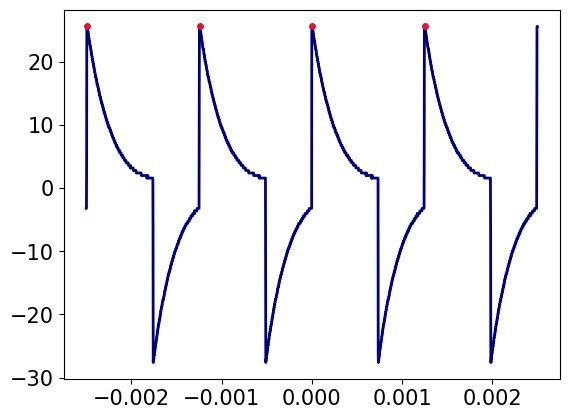

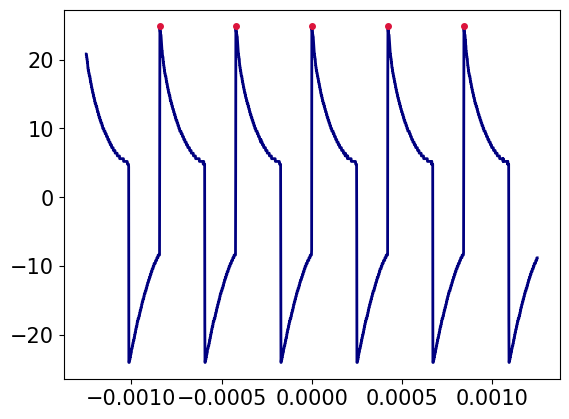

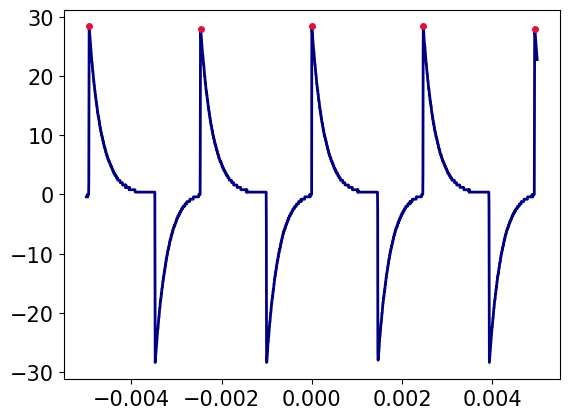

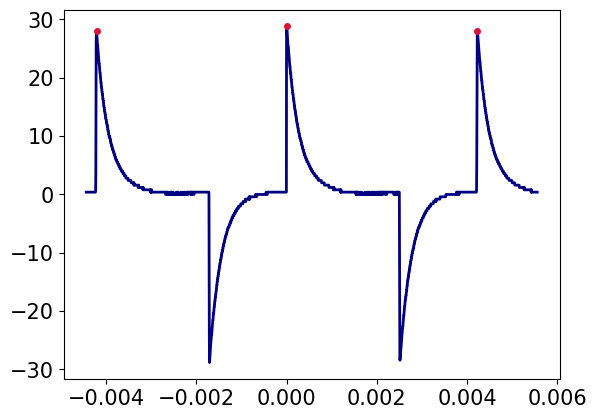

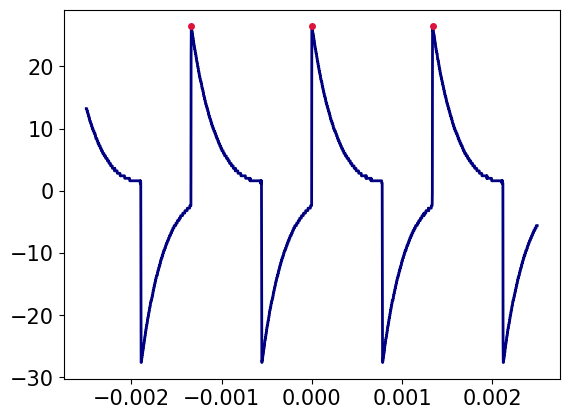

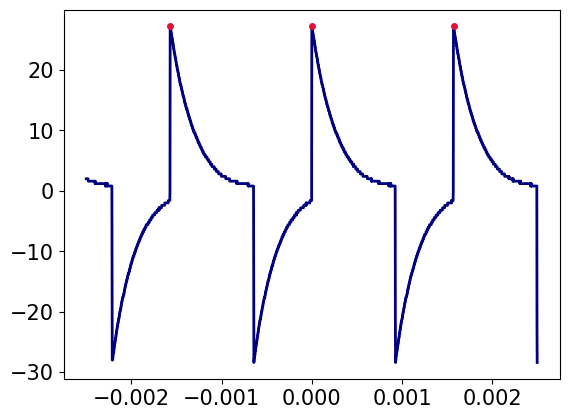

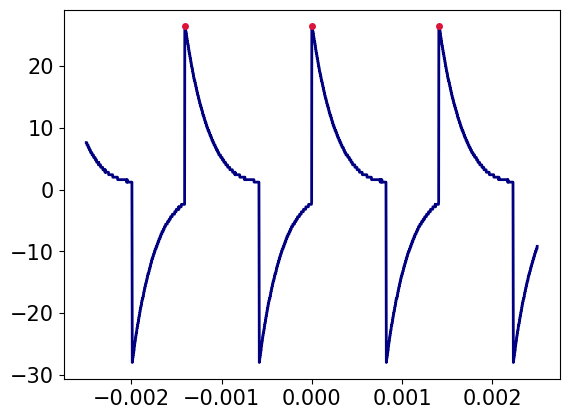

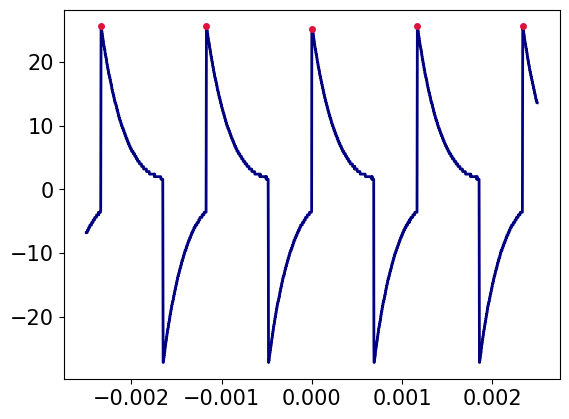

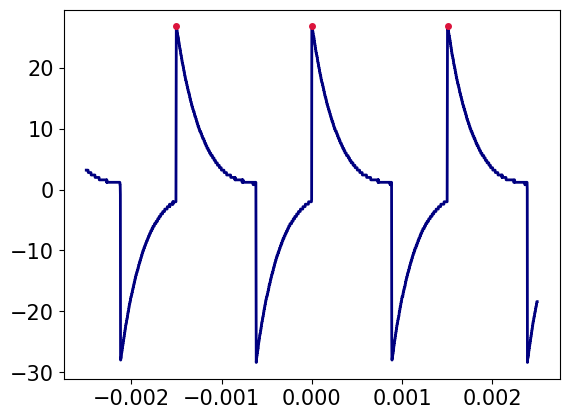

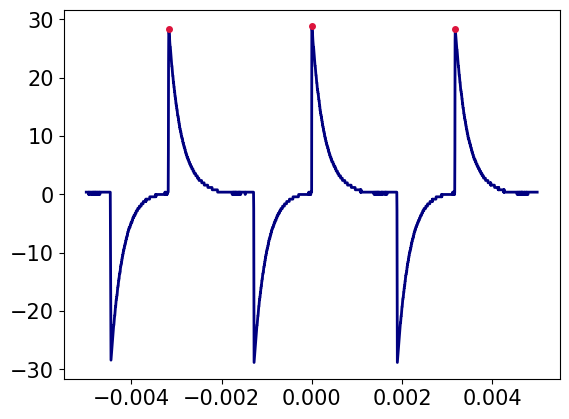

[ 289.01734104  225.09848059  267.23677178  987.16683119 1637.33115023
  618.04697157  912.40875912  494.55984174  575.04312823  351.37034434
 1284.52151574  250.62656642 1097.09270433  597.37156511  801.71031534
 2373.88724036  404.8582996   236.85457129  747.94315632  636.94267516
  710.22727273  855.79803166  665.33599468  315.05986137] [0.27270206 0.32033277 0.23314872 0.7953563  1.69484229 0.62352458
 0.67945314 0.61852026 0.53977336 0.40306104 1.34667682 0.20506655
 0.98235231 0.58250507 0.90860723 3.56267672 0.41449789 0.18314883
 0.91316193 0.66223375 0.82338946 0.92603799 0.72259117 0.324061  ]


In [6]:
files = os.listdir('special/barrido L')

names = []
for i in range(len(files)):
    if files[i].endswith('.csv'):
        names.append(int(files[i][:-4]))
names = np.array(names)

periods = []
err_periods = []
for name in names:
    df = pd.read_csv(f'special/barrido L/{name}.csv')
    err_t = (df.t[2499]-df.t[0])/len(df.t)
    
    pk_idx = pk(df.V_R,height=max(df.V_R)-5,distance=100)[0]
    n = len(pk_idx)
    
    periods.append(np.mean(np.diff(df.t[pk_idx])))
    err_periods.append(np.sqrt(2/n)*err_t)
    
    plt.scatter(df.t[pk_idx],df.V_R[pk_idx],c='crimson',zorder=2)
    plt.plot(df.t,df.V_R,'navy',zorder=1)
    plt.show()
periods = np.array(periods)
err_periods = np.array(err_periods)
freqs = 1/periods
err_freqs = err_periods/periods**2
print(freqs,err_freqs)

In [18]:
err_L = names*(0.01+np.random.normal(0.0025,0.0025,len(names)))
err_log_freqs = err_freqs/freqs
err_log_L = err_L/names

-1.9880065886562548 17.65261649491678
0.9993921851740777
5.914438771686373


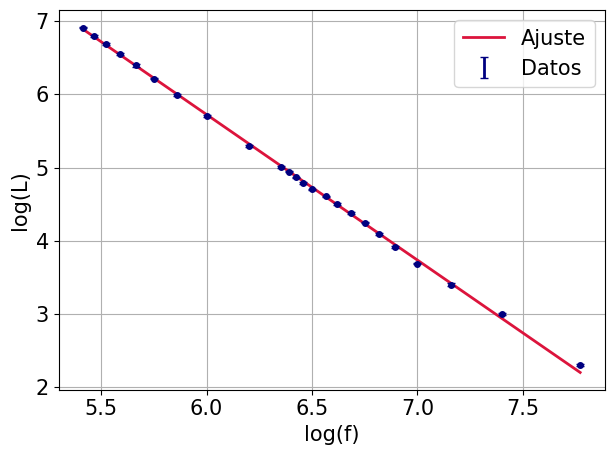

In [19]:
pars,cov = cf(lineal,np.log(freqs),np.log(names),sigma=err_log_L,absolute_sigma=True)
a,b = pars
err_a = cov[0,0]
err_b = cov[1,1]
x_adj = np.linspace(min(np.log(freqs)),max(np.log(freqs)))
y_adj = lineal(x_adj,*pars)
plt.scatter(np.log(freqs),np.log(names),c='navy',zorder=3)
plt.errorbar(np.log(freqs),np.log(names),yerr=err_log_L,fmt='None',ecolor='Navy',zorder=2,label='Datos')
plt.plot(x_adj,y_adj,'crimson',zorder=1,label='Ajuste')
plt.grid()
plt.xlabel('log(f)')
plt.ylabel('log(L)')
plt.legend()
plt.tight_layout()
plt.savefig('plots/lineal.png',bbox_inches='tight')

print(a,b)
print(r2(np.log(names),np.log(freqs),lineal,pars))
print(chi2_red(np.log(names),err_log_L,np.log(freqs),lineal,pars))

def inductance(f,a,b):
    return np.exp(b)*f**a

def err_inductance(f,a,b,err_f,err_a,err_b):
    return np.exp(b)*f**a * np.sqrt(err_b**2+a**2/f**2*err_f**2+np.log(abs(a))**2*err_a**2)

def omega(L,a,b):
    return np.exp(-b/a)*L**(1/a)

5.7399862591762805


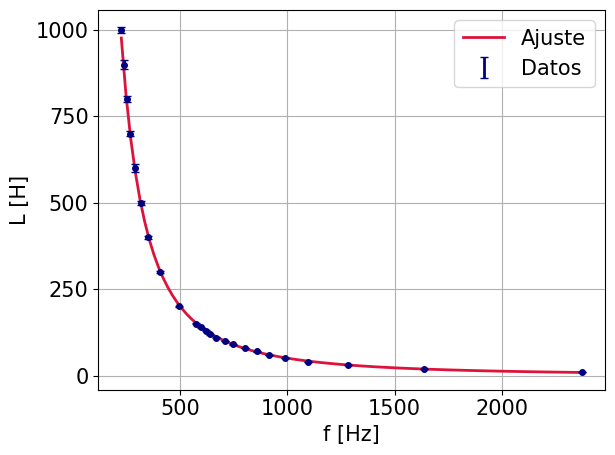

In [20]:
my_L = np.linspace(min(names),max(names),100)
my_w = np.linspace(min(freqs),max(freqs),100)

print(chi2_red(names,err_L,freqs,inductance,pars))

plt.scatter(freqs,names,c='navy',zorder=3)
plt.errorbar(freqs,names,yerr=err_L,fmt='None',ecolor='Navy',zorder=2,label='Datos')
plt.plot(my_w,inductance(my_w,a,b),'crimson',zorder=1,label='Ajuste')
plt.grid()
plt.xlabel('f [Hz]')
plt.ylabel('L [H]')
plt.locator_params(axis='y',nbins=5)
plt.legend()
plt.tight_layout()
plt.savefig('plots/normal.png',bbox_inches='tight')
plt.show()

In [21]:
def L_from_signal(name,folder,a,b,err_a,err_b,plot=False):
    df = pd.read_csv(f'special/{folder}/{name}.csv')
    
    pk_idx = pk(df.V_R,height=max(df.V_R)-5,distance=100)[0]
    
    period = np.mean(np.diff(df.t[pk_idx]))
    freq = 1/period

    err_t = (df.t[2499]-df.t[0])/len(df.t)
    err_period = np.sqrt(2/n)*err_t
    err_freq = err_period/period**2

    L = inductance(freq,a,b)
    err_L = err_inductance(freq,a,b,err_freq,err_a,err_b)
    
    if plot:
        plt.scatter(df.t[pk_idx],df.V_R[pk_idx],c='crimson',zorder=2)
        plt.plot(df.t,df.V_R,'navy',zorder=1)
        plt.show()
    
    return L,err_L

def L_volume(L_aire,L_m,V,V_x):
    Lx = V/V_x * (L_m-L_aire) + L_aire
    return Lx

In [22]:
aire_1600,err_aire_1600 =  L_from_signal('aire','1600',a,b,err_a,err_b)
aire_larga,err_aire_larga =  L_from_signal('aire','larga',a,b,err_a,err_b)
for material in ['aluminio','bronce','cobre','laton','niquel','hierro 1','hierro 2','hierro 3','hierro fino']:
    print(f'{material}: {np.round(L_from_signal(material,"1600",a,b,err_a,err_b)[0]/aire_1600,2)}, {np.round(L_from_signal(material,"larga",a,b,err_a,err_b)[0]/aire_larga,2)}')

aluminio: 0.92, 0.94
bronce: 0.95, 0.96
cobre: 0.92, 0.95
laton: 0.98, 0.98
niquel: 1.17, 1.31
hierro 1: 1.95, 2.52
hierro 2: 2.71, 4.89
hierro 3: 3.51, 6.02
hierro fino: 1.71, 2.05


In [23]:
def mu_r(file,folder='1600',a=a,b=b,err_a=err_a,err_b=err_b,aire=aire_1600,err_aire=err_aire_1600):
    L_mat,err_L_mat = L_from_signal(file,folder,a,b,err_a,err_b)
    mu = L_mat/aire
    err_mu = np.sqrt(err_L_mat**2/aire**2 + mu**2/aire**2*err_aire**2)
    return mu,err_mu

In [24]:
files_materials = os.listdir('special/1600')
files_materials.sort()

for file in files_materials:
    mat = file[:-4]
    if file != 'aire.csv':
        print(f'{mat}: {np.round(mu_r(mat),3)}')

aluminio: [0.918 0.009]
bronce: [0.945 0.009]
cobre: [0.923 0.009]
entrehierro 1: [6.322 0.047]
entrehierro 3: [10.435  0.075]
entrehierro 6: [82.086  0.643]
hierro 1: [1.951 0.016]
hierro 2: [2.708 0.022]
hierro 3: [3.514 0.027]
hierro 4: [4.462 0.034]
hierro fino: [1.707 0.015]
hierro: [3.565 0.028]
laton: [0.975 0.01 ]
niquel: [1.165 0.011]


In [25]:
mu_teoricas = {'Aluminio':1.000022,'Bronce':1.12,'Cobre':0.999994,'Hierro':5000,'Latón':1.06,'Níquel':300}

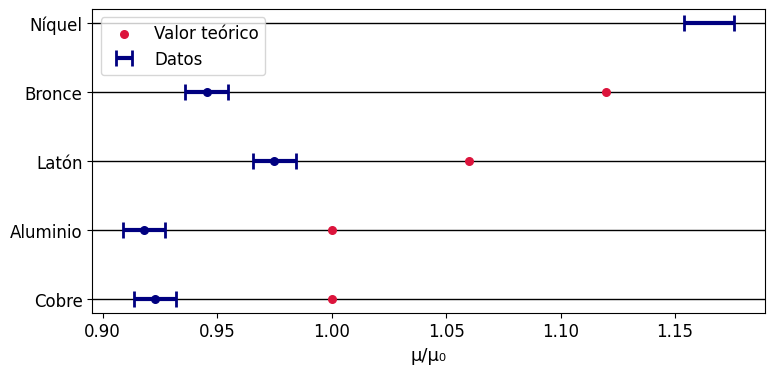

In [45]:
materials = ['Cobre','Aluminio','Latón','Bronce','Níquel']
measured_values = []
theoretical_values = []
uncertainties = []
for mat in materials:
    if mat == 'Latón':
        mus = mu_r('laton')
    elif mat == 'Níquel':
        mus = mu_r('niquel')
    else:
        mus = mu_r(mat.lower())
    measured_values.append(mus[0])
    uncertainties.append(mus[1])
    theoretical_values.append(mu_teoricas[mat])


y_values = np.arange(len(materials))
fig, ax = plt.subplots(figsize=(8,4),layout='tight')
ax.errorbar(measured_values, y_values, xerr=uncertainties, fmt='None', elinewidth=3, capsize=6, capthick=2, c='navy', label='Datos',zorder=2)
ax.scatter(measured_values[:-1], y_values[:-1], s=30, color='navy', marker='o',zorder=3)
ax.scatter(theoretical_values[:-1], y_values[:-1], s=30, color='crimson', marker='o', label='Valor teórico',zorder=3)
for y_val in y_values:
    ax.axhline(y_val, color='black', linewidth=1,alpha=1,zorder=1)

ax.set_yticks(y_values)
ax.set_yticklabels(materials)
ax.set_xlabel('\u03BC/\u03BC\u2080',fontsize=13)
ax.legend(fontsize=12,loc=2)
ax.tick_params(axis='both',labelsize=12)
plt.savefig('plots/perms.png',bbox_inches='tight')

/home/seke/.local/lib/python3.10/site-packages/brokenaxes.py:316: UserWarning: FixedFormatter should only be used together with FixedLocator
  result.append(getattr(ax, method)(*args, **kwargs))


dict_values(['Varilla', '2 varillas', '3 varillas', '4 varillas', 'Lámina', 'Núcleo interno', 'Núcleo abierto', 'Núcleo cerrado'])


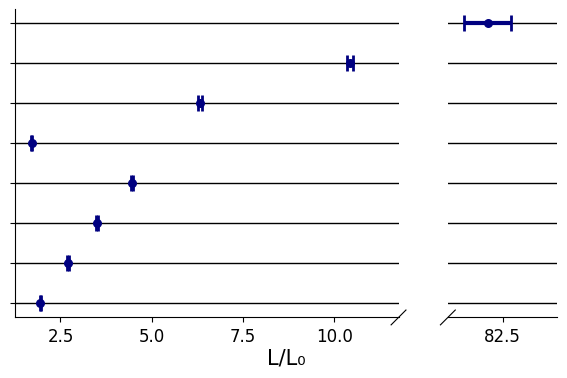

In [126]:
from brokenaxes import brokenaxes
geometrias = ['hierro 1','hierro 2','hierro 3','hierro 4','hierro fino','entrehierro 1','entrehierro 3','entrehierro 6']
nombres = {'hierro 1':'Varilla','hierro 2':'2 varillas','hierro 3':'3 varillas','hierro 4':'4 varillas','hierro fino':'Lámina','entrehierro 1':'Núcleo interno',
           'entrehierro 3':'Núcleo abierto','entrehierro 6':'Núcleo cerrado'}

measured_values = []
uncertainties = []
for mat in geometrias:
    mus = mu_r(mat.lower())
    measured_values.append(mus[0])
    uncertainties.append(mus[1])


y_values = np.arange(len(geometrias))
fig = plt.figure(figsize=(7, 4))
bax = brokenaxes(xlims=[(1.25, 11.76), (81, 84)], hspace=0.05)

bax.errorbar(measured_values, y_values, xerr=uncertainties, fmt='None', elinewidth=3, capsize=6, capthick=2, c='navy',
             label='Datos', zorder=2)
bax.scatter(measured_values, y_values, s=30, color='navy', marker='o', zorder=3)

for y_val in y_values:
    bax.axhline(y_val, color='black', linewidth=1, alpha=1, zorder=1)

bax.set_yticklabels(['','','','','','','',''])
print(nombres.values())

bax.set_xlabel('L/L\u2080', fontsize=15,labelpad=22)
bax.tick_params(axis='both', labelsize=12)


bax.locator_params(axis='x',nbins=5)
plt.savefig('plots/hierros.png',bbox_inches='tight')

Text(0, 0.5, 'value')

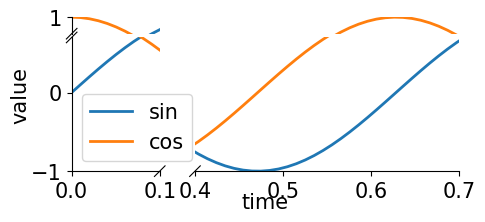

In [62]:
fig = plt.figure(figsize=(5, 2))
bax = brokenaxes(xlims=((0, .1), (.4, .7)), ylims=((-1, .7), (.79, 1)), hspace=.05)
x = np.linspace(0, 1, 100)
bax.plot(x, np.sin(10 * x), label='sin')
bax.plot(x, np.cos(10 * x), label='cos')
bax.legend(loc=3)
bax.set_xlabel('time')
bax.set_ylabel('value')